<a href="https://colab.research.google.com/github/zeyuanyin/ml801/blob/main/lab_1/lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Foundations and Advanced Topics in Machine Learning Lab ML801b -- Deep Learning (1)


Lab Target: Train deep networks with different normalizations, regularizations, and activation functions, and compare their performance in training and testing.

- Batch Norm
- Dropout

### Part 1: train a neural netwrok

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

/home/zeyuan.yin/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 10
        self.lr = 0.01
        self.gamma = 0.7
        self.no_cuda = False
        self.no_mps = False
        self.seed = 1
args = Args()

use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset1 = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataset2 = datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=args.batch_size, num_workers=4, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=args.batch_size, num_workers=4, pin_memory=True, shuffle=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 85496879.33it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 132067.17it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 885702.02it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23008.99it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader)
    acc = 100. * correct / len(train_loader.dataset)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset), acc))

    return train_loss, acc


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    acc = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))

    return test_loss, acc


def launch_training(model):
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    for epoch in range(1, args.epochs + 1):
        print(f'Epoch: {epoch}')
        train_loss, train_acc = train(args, model, device, train_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, test_loader)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        scheduler.step()

    return [train_loss_list, test_loss_list], [train_acc_list, test_acc_list]

In [5]:
import matplotlib.pyplot as plt

def plot_loss_and_acc(title='Loss and Accuracy Curve', loss_list=None, acc_list=None):
    epochs = [i for i in range(1, len(loss_list[0]) + 1)]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_list[0], label='Train Loss', marker='o', linestyle='-')
    plt.plot(epochs, loss_list[1], label='Test Loss', marker='o', linestyle='-')
    plt.xticks(epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True, axis='y')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_list[0], label='Train Accuracy', marker='o', linestyle='-')
    plt.plot(epochs, acc_list[1], label='Test Accuracy', marker='o', linestyle='-')
    plt.xticks(epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.grid(True, axis='y')

    last_test_acc = acc_list[1][-1]
    plt.text(epochs[-1]+0.3, last_test_acc, f'{last_test_acc:.2f}', ha='right', va='bottom')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

Epoch: 1
Train set: Average loss: 0.4316, Accuracy: 50866/60000 (84.78%)
Test set: Average loss: 0.3578, Accuracy: 8699/10000 (86.99%)

Epoch: 2
Train set: Average loss: 0.2772, Accuracy: 53853/60000 (89.75%)
Test set: Average loss: 0.2942, Accuracy: 8934/10000 (89.34%)

Epoch: 3
Train set: Average loss: 0.2255, Accuracy: 54978/60000 (91.63%)
Test set: Average loss: 0.2766, Accuracy: 9042/10000 (90.42%)

Epoch: 4
Train set: Average loss: 0.1845, Accuracy: 55825/60000 (93.04%)
Test set: Average loss: 0.2789, Accuracy: 9039/10000 (90.39%)

Epoch: 5
Train set: Average loss: 0.1538, Accuracy: 56533/60000 (94.22%)
Test set: Average loss: 0.2812, Accuracy: 9088/10000 (90.88%)

Epoch: 6
Train set: Average loss: 0.1289, Accuracy: 57117/60000 (95.19%)
Test set: Average loss: 0.2892, Accuracy: 9091/10000 (90.91%)

Epoch: 7
Train set: Average loss: 0.1089, Accuracy: 57596/60000 (95.99%)
Test set: Average loss: 0.3057, Accuracy: 9124/10000 (91.24%)

Epoch: 8
Train set: Average loss: 0.0945, Accura

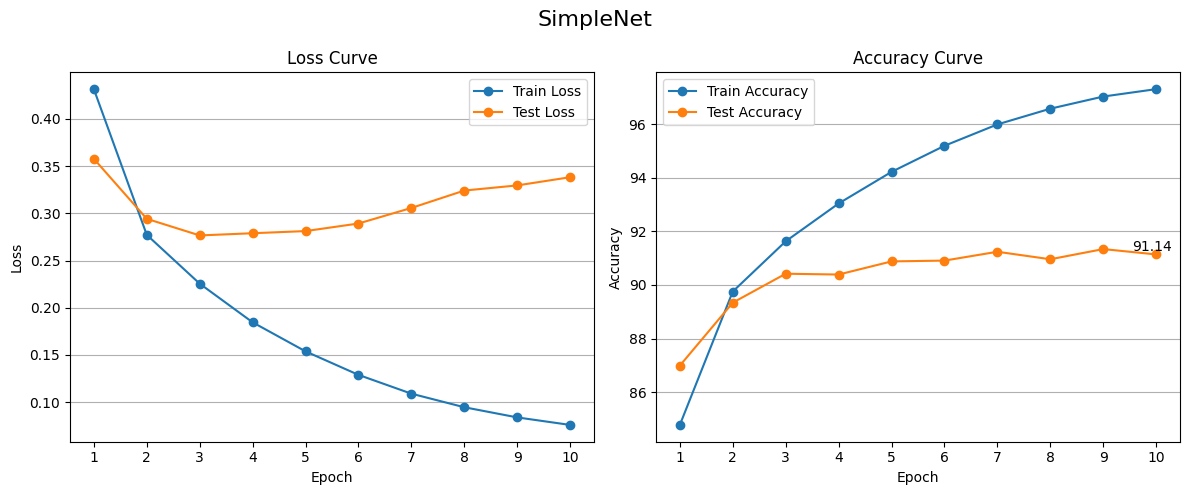

In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = SimpleNet().to(device)
loss_list, acc_list = launch_training(model)
plot_loss_and_acc(title='SimpleNet', loss_list=loss_list, acc_list = acc_list)

### Part 2: Add Dropout to avoid overfitting

Epoch: 1
Train set: Average loss: 0.4638, Accuracy: 50104/60000 (83.51%)
Test set: Average loss: 0.3381, Accuracy: 8788/10000 (87.88%)

Epoch: 2
Train set: Average loss: 0.3165, Accuracy: 52944/60000 (88.24%)
Test set: Average loss: 0.2942, Accuracy: 8888/10000 (88.88%)

Epoch: 3
Train set: Average loss: 0.2693, Accuracy: 54061/60000 (90.10%)
Test set: Average loss: 0.2623, Accuracy: 9036/10000 (90.36%)

Epoch: 4
Train set: Average loss: 0.2366, Accuracy: 54703/60000 (91.17%)
Test set: Average loss: 0.2566, Accuracy: 9059/10000 (90.59%)

Epoch: 5
Train set: Average loss: 0.2085, Accuracy: 55271/60000 (92.12%)
Test set: Average loss: 0.2436, Accuracy: 9118/10000 (91.18%)

Epoch: 6
Train set: Average loss: 0.1870, Accuracy: 55783/60000 (92.97%)
Test set: Average loss: 0.2398, Accuracy: 9154/10000 (91.54%)

Epoch: 7
Train set: Average loss: 0.1770, Accuracy: 56004/60000 (93.34%)
Test set: Average loss: 0.2334, Accuracy: 9165/10000 (91.65%)

Epoch: 8
Train set: Average loss: 0.1630, Accura

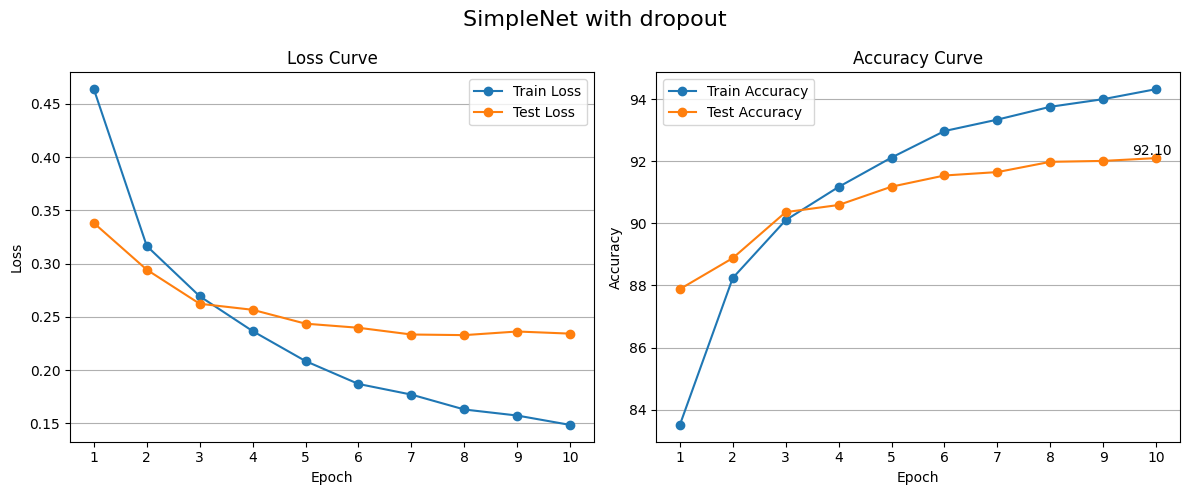

In [8]:
class SimpleNet_w_dropout(nn.Module):
    def __init__(self):
        super(SimpleNet_w_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)     # add dropout
        self.dropout2 = nn.Dropout(0.1)     # add dropout

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)                # apply dropout
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)                # apply dropout
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = SimpleNet_w_dropout().to(device)
loss_list, acc_list = launch_training(model)
plot_loss_and_acc(title='SimpleNet with dropout', loss_list=loss_list, acc_list = acc_list)

### Part 3: Batch Norm

$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$

Epoch: 1
Train set: Average loss: 0.3712, Accuracy: 51875/60000 (86.46%)
Test set: Average loss: 0.2985, Accuracy: 8882/10000 (88.82%)

Epoch: 2
Train set: Average loss: 0.2390, Accuracy: 54696/60000 (91.16%)
Test set: Average loss: 0.2360, Accuracy: 9119/10000 (91.19%)

Epoch: 3
Train set: Average loss: 0.1838, Accuracy: 55883/60000 (93.14%)
Test set: Average loss: 0.2474, Accuracy: 9133/10000 (91.33%)

Epoch: 4
Train set: Average loss: 0.1438, Accuracy: 56766/60000 (94.61%)
Test set: Average loss: 0.2056, Accuracy: 9285/10000 (92.85%)

Epoch: 5
Train set: Average loss: 0.1085, Accuracy: 57639/60000 (96.06%)
Test set: Average loss: 0.2105, Accuracy: 9310/10000 (93.10%)

Epoch: 6
Train set: Average loss: 0.0824, Accuracy: 58170/60000 (96.95%)
Test set: Average loss: 0.2161, Accuracy: 9328/10000 (93.28%)

Epoch: 7
Train set: Average loss: 0.0627, Accuracy: 58660/60000 (97.77%)
Test set: Average loss: 0.2264, Accuracy: 9326/10000 (93.26%)

Epoch: 8
Train set: Average loss: 0.0492, Accura

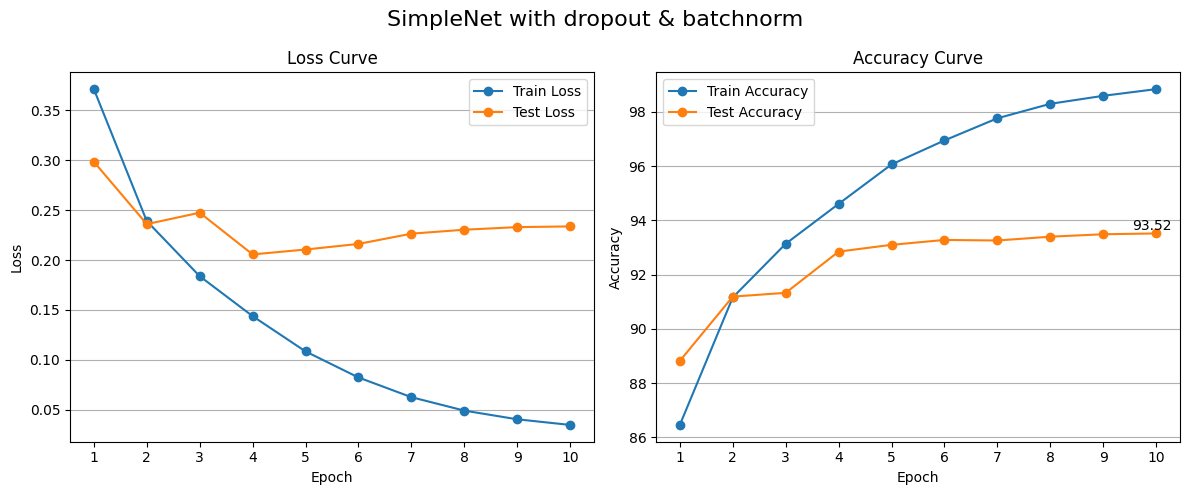

In [9]:
class SimpleNet_w_dropout_w_bn(nn.Module):
    def __init__(self):
        super(SimpleNet_w_dropout_w_bn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv1_bn = nn.BatchNorm2d(32)  # add BN
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv2_bn = nn.BatchNorm2d(64)  # add BN
        self.fc1 = nn.Linear(9216, 128)
        self.fc1_bn = nn.BatchNorm1d(128)   # add BN
        self.fc2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)                # apply BN
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)                # apply BN
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc1_bn(x)                  # apply BN
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = SimpleNet_w_dropout_w_bn().to(device)
loss_list, acc_list = launch_training(model)
plot_loss_and_acc(title='SimpleNet with dropout & batchnorm', loss_list=loss_list, acc_list = acc_list)

### Practice in Class:（not graded）

Now it's your turn. Try different stratages and compare their performance in training and testing.

- normalization
    - try different normalization position
    - use other normalization, like group norm
- regularization
    - adjust other drop-out ratio settings
    - use other regularization, like DropBlock
- activation functions
    - try different activation functions, like PReLU

<img src="https://github.com/zeyuanyin/ml801/blob/main/lab_1/image.png?raw=1" alt="Image" style="width:30%;">
<img src="https://github.com/zeyuanyin/ml801/blob/main/lab_1/image-1.png?raw=1" alt="Image" style="width:30%;">
<img src="https://github.com/zeyuanyin/ml801/blob/main/lab_1/image-2.png?raw=1" alt="Image" style="width:30%;">